# SMS Spam Classification – Notebook corregido
Este cuaderno soluciona los errores de forma y vacíos que provocaban fallos en el entrenamiento.

In [5]:
!wget https://github.com/javierherrera1996/lecture_analytics/raw/refs/heads/main/datasets/exploracion_datos/Gender_bias_spanish.csv

--2025-05-28 18:27:13--  https://github.com/javierherrera1996/lecture_analytics/raw/refs/heads/main/datasets/exploracion_datos/Gender_bias_spanish.csv
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/javierherrera1996/lecture_analytics/refs/heads/main/datasets/exploracion_datos/Gender_bias_spanish.csv [following]
--2025-05-28 18:27:13--  https://raw.githubusercontent.com/javierherrera1996/lecture_analytics/refs/heads/main/datasets/exploracion_datos/Gender_bias_spanish.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 205292 (200K) [text/plain]
Saving to: ‘Gender_bias_spanish.csv.1’

Gender_bias

## 0. Descarga y limpieza del dataset

In [6]:
import pandas as pd, numpy as np, tensorflow as tf
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Descarga (solo la primera vez)
!wget -q -O spam.csv https://raw.githubusercontent.com/javierherrera1996/IntroMachineLearning/refs/heads/main/TercerCorte/spam.csv

# Cargar CSV con codificación correcta y quedarnos con columnas relevantes
df = (pd.read_csv("spam.csv", encoding="ISO-8859-1")
        .rename(columns={'v1':'label', 'v2':'text'})
        [['label','text']])

# Eliminar filas con texto vacío o nulo
df = df.dropna(subset=['text'])
df = df[df['text'].str.strip().astype(bool)]

df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## 1. Configuración y seed

In [7]:
AUTOTUNE = tf.data.AUTOTUNE
np.random.seed(42)
tf.random.set_seed(42)


## 2. División Train/Test

In [8]:
y = df['label'].map({'ham':0,'spam':1})
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], y, test_size=0.2, stratify=y, random_state=42)

print(len(X_train),"train |", len(X_test),"test")


4457 train | 1115 test


## 3. Vectorización de texto con manejo seguro de dimensiones

In [9]:
MAX_TOKENS, MAX_LEN = 10000, 100
vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=MAX_TOKENS,
    output_sequence_length=MAX_LEN,
    standardize="lower_and_strip_punctuation")
vectorizer.adapt(X_train.values)

def to_tensor(txt, label):
    txt = tf.expand_dims(txt, -1)          # (1,)
    seq = tf.squeeze(vectorizer(txt), axis=0) # (MAX_LEN,)
    return seq, label

batch = 32
train_ds = (tf.data.Dataset.from_tensor_slices((X_train.values, y_train.values))
            .shuffle(10000)
            .map(to_tensor, num_parallel_calls=AUTOTUNE)
            .batch(batch)
            .prefetch(AUTOTUNE))
test_ds  = (tf.data.Dataset.from_tensor_slices((X_test.values, y_test.values))
            .map(to_tensor, num_parallel_calls=AUTOTUNE)
            .batch(batch)
            .prefetch(AUTOTUNE))


## 4. Definición y entrenamiento del modelo

In [10]:
EMBED_DIM = 16
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(MAX_TOKENS, EMBED_DIM, input_length=MAX_LEN),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(train_ds, validation_data=test_ds, epochs=5)


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.8429 - loss: 0.4655 - val_accuracy: 0.8664 - val_loss: 0.3704
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8743 - loss: 0.3661 - val_accuracy: 0.8664 - val_loss: 0.3651
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8595 - loss: 0.3814 - val_accuracy: 0.8664 - val_loss: 0.3581
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8662 - loss: 0.3676 - val_accuracy: 0.8664 - val_loss: 0.3504
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8670 - loss: 0.3572 - val_accuracy: 0.8664 - val_loss: 0.3351


## 5. Curva de aprendizaje

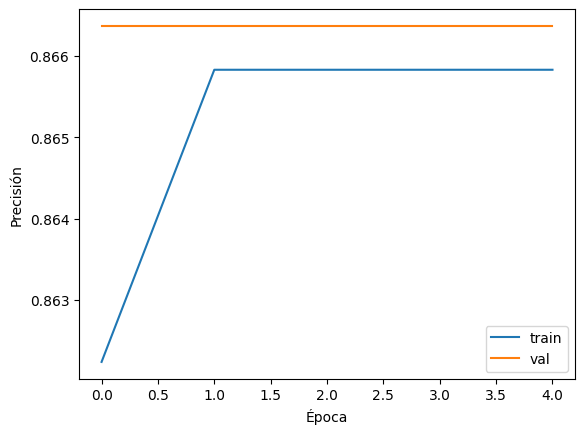

In [11]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend(); plt.xlabel('Época'); plt.ylabel('Precisión'); plt.show()


## 6. Evaluación

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
              precision    recall  f1-score   support

         ham       0.87      1.00      0.93       966
        spam       0.00      0.00      0.00       149

    accuracy                           0.87      1115
   macro avg       0.43      0.50      0.46      1115
weighted avg       0.75      0.87      0.80      1115



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


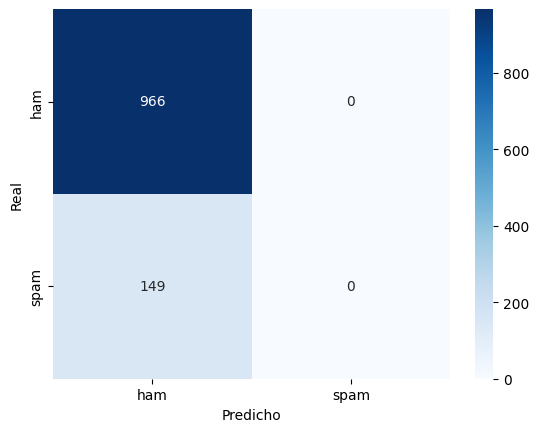

AUC: 0.9558408715105535


In [12]:
y_prob = model.predict(test_ds).ravel()
y_pred = (y_prob > 0.4).astype(int)   # Umbral 0.4 para mejorar recall spam
y_true = y_test.values

print(classification_report(y_true, y_pred, target_names=['ham','spam']))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ham','spam'], yticklabels=['ham','spam'])
plt.xlabel('Predicho'); plt.ylabel('Real'); plt.show()

fpr,tpr,_ = roc_curve(y_true, y_prob)
print("AUC:", auc(fpr,tpr))


## 7. Próximos pasos
- Aumentar `epochs` si no hay sobreajuste.
- Probar `class_weight={0:1,1:2}` en `model.fit`.
- Cambiar la arquitectura a `Bidirectional(LSTM(32))` para capturar contexto.
- Usar embeddings preentrenados (GloVe) para menos datos.

In [13]:
history = model.fit(train_ds, validation_data=test_ds, epochs=10) # Aumentar epochs a 10 (ejemplo)

Epoch 1/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8695 - loss: 0.3277 - val_accuracy: 0.8664 - val_loss: 0.3121
Epoch 2/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8655 - loss: 0.3101 - val_accuracy: 0.8664 - val_loss: 0.2769
Epoch 3/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8675 - loss: 0.2650 - val_accuracy: 0.8753 - val_loss: 0.2197
Epoch 4/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9016 - loss: 0.2069 - val_accuracy: 0.9283 - val_loss: 0.1712
Epoch 5/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9586 - loss: 0.1505 - val_accuracy: 0.9758 - val_loss: 0.1143
Epoch 6/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9764 - loss: 0.1085 - val_accuracy: 0.9686 - val_loss: 0.0994
Epoch 7/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9786 - loss: 0.0821 - val_accuracy: 0.9758 - val_loss: 0.0788
Epoch 8/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9838 - loss: 0.0682 - val_accuracy: 0

In [14]:
history = model.fit(train_ds, validation_data=test_ds, epochs=10, class_weight={0: 1, 1: 2})

Epoch 1/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.9833 - loss: 0.0932 - val_accuracy: 0.9776 - val_loss: 0.0824
Epoch 2/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9864 - loss: 0.0874 - val_accuracy: 0.9830 - val_loss: 0.0620
Epoch 3/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9885 - loss: 0.0587 - val_accuracy: 0.9821 - val_loss: 0.0604
Epoch 4/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9871 - loss: 0.1036 - val_accuracy: 0.9821 - val_loss: 0.0620
Epoch 5/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9907 - loss: 0.0630 - val_accuracy: 0.9830 - val_loss: 0.0611
Epoch 6/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9911 - loss: 0.0537 - val_accuracy: 0.9830 - val_loss: 0.0593
Epoch 7/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9892 - loss: 0.0632 - val_accuracy: 0.9830 - val_loss: 0.0642
Epoch 8/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.9891 - loss: 0.0575 - val_accuracy: 

In [15]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(MAX_TOKENS, EMBED_DIM, input_length=MAX_LEN),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


--2025-05-28 18:29:08--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-05-28 18:29:08--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-05-28 18:29:08--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 16s 83ms/step - accuracy: 0.8605 - loss: 0.3930 - val_accuracy: 0.9453 - val_loss: 0.1639
Epoch 2/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.9576 - loss: 0.1537 - val_accuracy: 0.9435 - val_loss: 0.1387
Epoch 3/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.9650 - loss: 0.1169 - val_accuracy: 0.9614 - val_loss: 0.1074
Epoch 4/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 11s 78ms/step - accuracy: 0.9698 - loss: 0.1025 - val_accuracy: 0.9641 - val_loss: 0.1144
Epoch 5/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 20s 73ms/step - accuracy: 0.9721 - loss: 0.0942 - val_accuracy: 0.9605 - val_loss: 0.1355
Epoch 6/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 21s 79ms/step - accuracy: 0.9684 - loss: 0.0892 - val_accuracy: 0.9722 - val_loss: 0.0814
Epoch 7/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.9810 - loss: 0.0700 - val_accuracy: 0.9776 - val_loss: 0.0893
Epoch 8/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - accuracy: 0.9796 - loss: 0.0676 - va

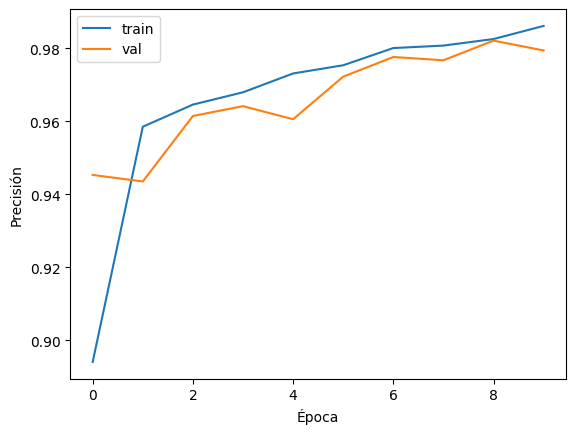

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
              precision    recall  f1-score   support

         ham       0.98      0.99      0.99       966
        spam       0.96      0.89      0.92       149

    accuracy                           0.98      1115
   macro avg       0.97      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



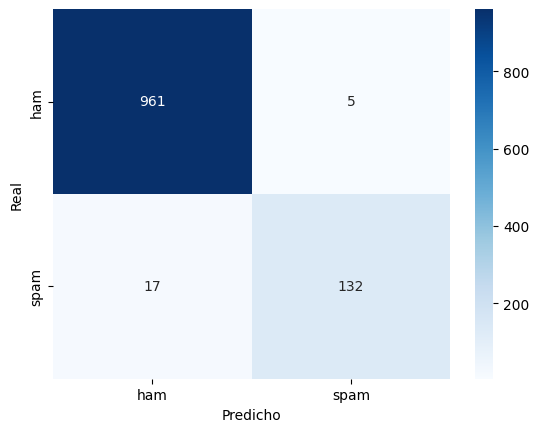

AUC: 0.9859935803910126


In [16]:
import matplotlib.pyplot as plt
import numpy as np
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

# Create a dictionary mapping words to their GloVe embeddings
path_to_glove_file = 'glove.6B.50d.txt' # Using 50-dimensional GloVe embeddings

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors.")

# Prepare embedding matrix
EMBED_DIM = 50 # GloVe 50d
vocabulary = vectorizer.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary))))

num_tokens = min(MAX_TOKENS, len(vocabulary))
embedding_matrix = np.zeros((num_tokens, EMBED_DIM))
for word, i in word_index.items():
    if i < MAX_TOKENS:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

# Create an Embedding layer with pre-trained weights
embedding_layer = tf.keras.layers.Embedding(
    num_tokens,
    EMBED_DIM,
    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
    trainable=False, # Set trainable=False to keep the embeddings fixed
    input_length=MAX_LEN
)

# Redefine the model using the pre-trained embedding layer
model = tf.keras.Sequential([
    embedding_layer,
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Train the model with pre-trained embeddings
history = model.fit(train_ds, validation_data=test_ds, epochs=10)

# Plot learning curve
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend(); plt.xlabel('Época'); plt.ylabel('Precisión'); plt.show()

# Evaluate the model
y_prob = model.predict(test_ds).ravel()
y_pred = (y_prob > 0.4).astype(int)   # Umbral 0.4 para mejorar recall spam
y_true = y_test.values

print(classification_report(y_true, y_pred, target_names=['ham','spam']))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ham','spam'], yticklabels=['ham','spam'])
plt.xlabel('Predicho'); plt.ylabel('Real'); plt.show()

fpr,tpr,_ = roc_curve(y_true, y_prob)
print("AUC:", auc(fpr,tpr))